# Week 3: CNN Cancer Detection Kaggle Mini-Project


**Problem Description**

This week's project works with image classification.    Specifically, it focuses on nearly 220,000 images of cancer cells with labels of benign or malignant. I chose to use convolutional neural networks (CNN basic and complex) to identify patterns and features that could indicate the presence or absence of cancer.  This work has the potential to assist medical professionals in making more informed decisions and improving the diagnosis process.

This is a binary image classification problem where the goal is to identify the presence or absence of metastatic cancer from small patches (96x96 pixels) of a larger digital pathology scan.     Each image corresponds to a label:
1: The presence of metastatic cancer.
0: There is no metastatic cancer.

**Github URL**

https://github.com/rayrelay/DeepLearning-Week3-Cancer


**Dataset Description**

DataSource: [Histopathologic Cancer Detection on Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/) 

In this dataset, 22,000 pathological images need to be classified. There are two folders: train for training samples and test for validation samples. In train_label.csv, the id column records the file name of the pathological image, and lable records the label.

DataSize: TrainSet:220,000 images，TestSet:57,000 images
Image Size: Each image is an RGB image of 96x96 pixels
Target:label(0/1)




**Conclusion**

In this project, I construct and optimize a deep learning model based on convolutional neural network (CNN) for the binary classification problem of histopathological cancer detection. The main results and summary of the project are as follows:
1. Data scale
Train images ：1000
Epochs ：10

2. Model performance improvement
Basic CNN model:
Verification set accuracy: 61%
AUC: 0.7065
The model after adjusting hyperparameters:
Verification set accuracy: 70%
AUC: 0.8268
By adjusting the hyperparameters, the verification set accuracy of the model is improved by 9.5% and the AUC is improved by 0.1203. This shows that hyperparameter optimization significantly improves the classification performance and generalization ability of the model.

3. Key improvement measures
Hyperparameter adjustment:
Use smaller learning rates (e.g. 0.0001) and learning rate scheduling (e.g. ReduceLROnPlateau) to make the training process more stable.
Adjust batch size and Dropout rate to reduce overfitting.
Data enhancement:
By means of data enhancement techniques such as random rotation, translation, scaling and flipping, the diversity of training data is increased and the generalization ability of the model is improved.
Model architecture optimization:
The convolutional layer and fully connected layer are added to improve the expressiveness of the model.
The L2 regularization and Dropout layers are added to further reduce overfitting.

4. Result analysis
Verification set accuracy:
After adjusting the hyperparameters, the validation set accuracy of the model is improved from 61% to 70%, indicating that the classification ability of the model on unseen data is significantly enhanced.


# Import libraries

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

import os
import numpy as np
import pandas as pd
import random
import shutil
from PIL import Image
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Exploratory data analysis（EDA）

By calculating the number of lines in the train\u labels.csv file, a total of 22025 training images are displayed, which matches the number of files in the train directory. 59% (130908) of the images showed no cancer, and 41% (89117) of the images showed cancer. A small number of sample images are displayed to verify whether the images have been loaded successfully.

(1000, 2)
             label
count  1000.000000
mean      0.410000
std       0.492079
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
train pictures: 220025
test pictures: 57458


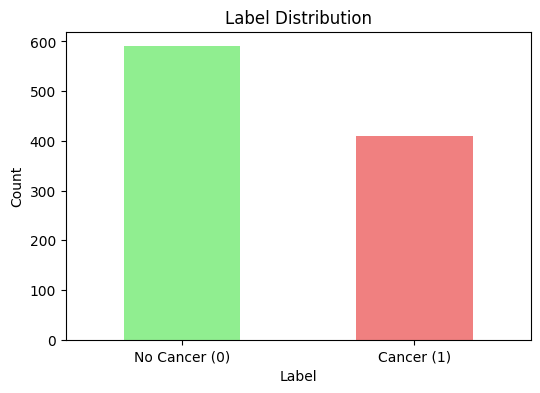

In [6]:
# Define paths
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
labels_file = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
submission_file = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

# load train labels
train_labels = pd.read_csv(labels_file).head(1000)

# view data
print(train_labels.shape)
print(train_labels.describe())
print(train_labels.head())

print(f'train pictures: {len(os.listdir("/kaggle/input/histopathologic-cancer-detection/train"))}')
print(f'test pictures: {len(os.listdir("/kaggle/input/histopathologic-cancer-detection/test"))}')

# Label Distribution
plt.figure(figsize=(6, 4))
train_labels['label'].value_counts().plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Cancer (0)', 'Cancer (1)'], rotation=0)
plt.show()

# Cancer Sample images


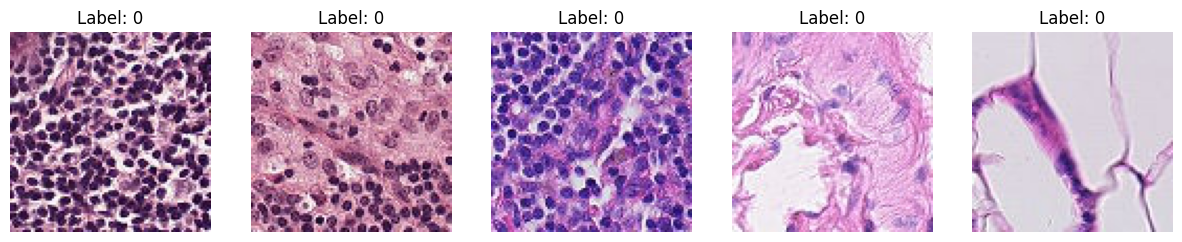

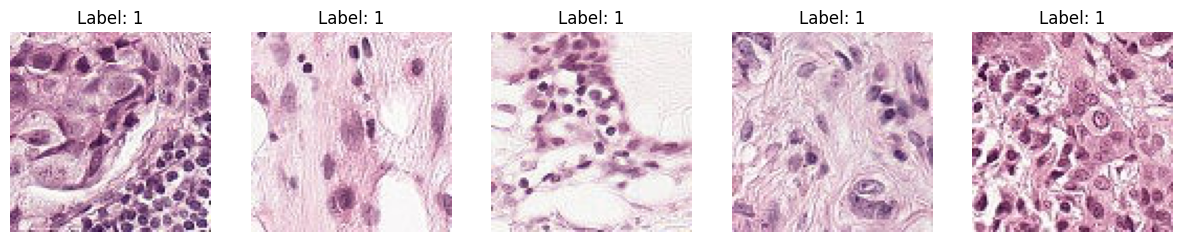

In [7]:

def plot_sample_images(df, path, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(df.sample(num_samples).iterrows()):
        img_id = row['id']
        label = row['label']
        img = Image.open(os.path.join(path, f"{img_id}.tif"))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# sample_images_label_0 / sample_images_label_1
sample_images_label_0 = train_labels[train_labels['label'] == 0].sample(6)
sample_images_label_1 = train_labels[train_labels['label'] == 1].sample(6)
plot_sample_images(sample_images_label_0, train_dir)
plot_sample_images(sample_images_label_1, train_dir)


# EDA Data preprocessing

**Optimize parameters - Add data enhancement**

Found 750 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
----Train----
Image Count: 750
Indexs: {'0': 0, '1': 1}
----Validator----
Image Count: 250
Indexs: {'0': 0, '1': 1}
Images: (64, 96, 96, 3)
Targets: (64,)


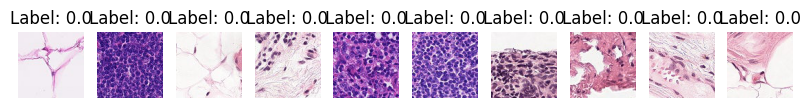

In [8]:
# Rescale pixel values, split for validation, and prepare ImageDataGenerators
batch_size = 64
target_size = (96, 96)

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image pixel values
    validation_split=0.25  # Reserve a portion for validation
)

# Update 'id' column to match file names
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')
train_labels['label'] = train_labels['label'].astype(str)

# train_df, valid_df = train_test_split(train_labels, test_size=0.2, random_state=1, stratify=train_labels.label)

# Initialize generators for train and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# 检查生成器的输出
print("----Train----")
print(f"Image Count: {train_generator.samples}")
print(f"Indexs: {train_generator.class_indices}")

print("----Validator----")
print(f"Image Count: {val_generator.samples}")
print(f"Indexs: {val_generator.class_indices}")

# 获取一个批次的数据
x_batch, y_batch = next(train_generator)

# 检查数据形状
print(f"Images: {x_batch.shape}")
print(f"Targets: {y_batch.shape}")

# 可视化一个批次的图像
plt.figure(figsize=(10, 5))
for i in range(min(10, x_batch.shape[0])):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {y_batch[i]}")
    plt.axis('off')
plt.show()

# Model building

**Building a simple CNN model**

**Model Training**


In [9]:
# Define the CNN architecture using Input object
cnn_model = Sequential([
    Input(shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
cnn_model.summary()

# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(train_labels) // batch_size,
    validation_data=val_generator,
    validation_steps=len(train_labels) // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 需要先确认验证集的steps数量
val_steps = len(val_generator) 
cnn_val_accuracy = cnn_model.evaluate(val_generator, steps=val_steps, verbose=0)[1]

print(f"sample CNN validation accuracy: {cnn_val_accuracy:.4f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 893ms/step - accuracy: 0.5799 - loss: 0.6967 - val_accuracy: 0.5781 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6406 - loss: 0.6838 - val_accuracy: 0.5172 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 603ms/step - accuracy: 0.5654 - loss: 0.6769 - val_accuracy: 0.5990 - val_loss: 0.6669 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5781 - loss: 0.6844 - val_accuracy: 0.5345 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 614ms/step - accuracy: 0.6207 - loss: 0.6546 - val_accuracy: 0.7135 - val_loss: 0.5517 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7391 - loss: 0.5868 - val_accuracy: 0.5862 - val_loss: 0.7239 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 621ms/step - accuracy: 0.6980 - loss: 0.6001 - val_accuracy: 0.7083 - val_loss: 0.5479 - learning_rate: 0.0010
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7969 - loss: 0.4595 - val_accuracy: 0.7586 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 623ms/step - accuracy: 0.7396 - loss: 0.5482 - val_accuracy:

# Visualizing training results

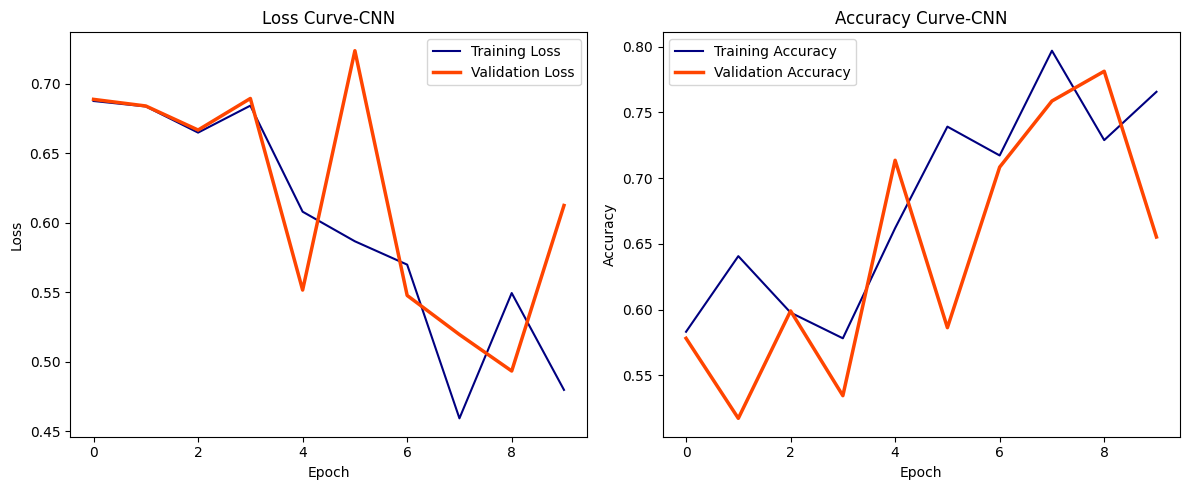


CNN AUC Score: 0.4657


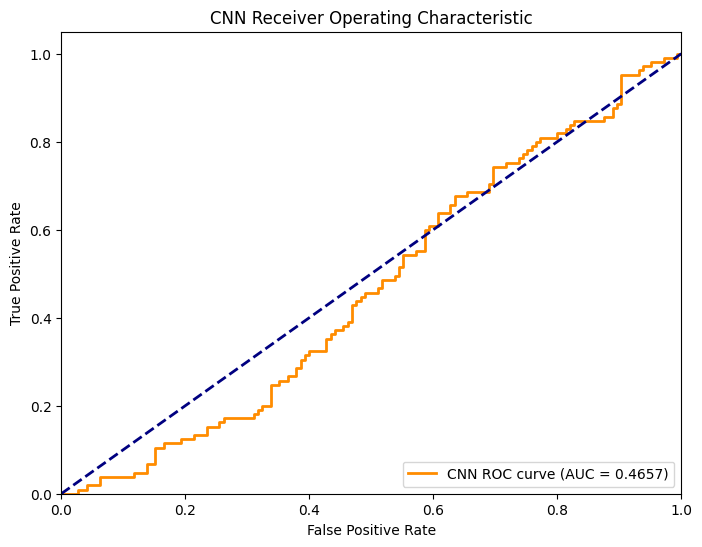

In [10]:
plt.figure(figsize=(12, 5))
# Loss Curve（CNN）
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss', color='navy')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='orangered',linewidth='2.5')
plt.title('Loss Curve-CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve（CNN）
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy Curve-CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# AUC评估（推荐使用生成器方式）
# 获取所有验证数据的预测概率
val_generator.reset()  # 重置生成器
y_pred_prob = cnn_model.predict(val_generator, verbose=0).ravel()
# 获取真实标签（需要确保生成器能返回对应标签）
# 如果使用ImageDataGenerator需要先提取标签
y_true = val_generator.classes
# 计算AUC
cnn_auc = roc_auc_score(y_true, y_pred_prob)
print(f"\nCNN AUC Score: {cnn_auc:.4f}")

# ROC曲线
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CNN ROC curve (AUC = {cnn_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Adjust hyperparameter

In [11]:
complex_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# By adjusting hyperparameters, the training process of the model is optimized

# smaller learning_rate
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

complex_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
complex_model.summary()

# 获取文件名与标签的映射
file_label_map = dict(zip(train_labels['id'], train_labels['label']))

# 按生成器文件顺序获取标签
y_train = np.array([int(file_label_map[f]) for f in train_generator.filenames])

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

complex_history = complex_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

val_steps = len(val_generator) 
complex_val_accuracy = complex_model.evaluate(val_generator, steps=val_steps, verbose=0)[1]
print(f"Adjust hyperparameter accuracy value: {complex_val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,740,097 (6.64 MB)

 Trainable params: 1,740,097 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 742ms/step - accuracy: 0.5004 - loss: 1.1622 - val_accuracy: 0.6000 - val_loss: 1.1318
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 649ms/step - accuracy: 0.5046 - loss: 1.1466 - val_accuracy: 0.5800 - val_loss: 1.0994
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 672ms/step - accuracy: 0.5736 - loss: 1.0993 - val_accuracy: 0.6480 - val_loss: 1.0806
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 718ms/step - accuracy: 0.5366 - loss: 1.0788 - val_accuracy: 0.6680 - val_loss: 1.0554
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 657ms/step - accuracy: 0.6024 - loss: 1.0534 - val_accuracy: 0.6600 - val_loss: 1.0382
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 655ms/step - accuracy: 0.5474 - loss: 1.0374 - val_accuracy: 0.6480 - val_loss: 1.0053
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 671ms/step - accuracy: 0.6718 - loss: 1.0064 - val_accuracy: 0.6760 - val_loss: 0.9984
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 613ms/step - accuracy: 0.5977 - loss: 0.9893 - val_accu

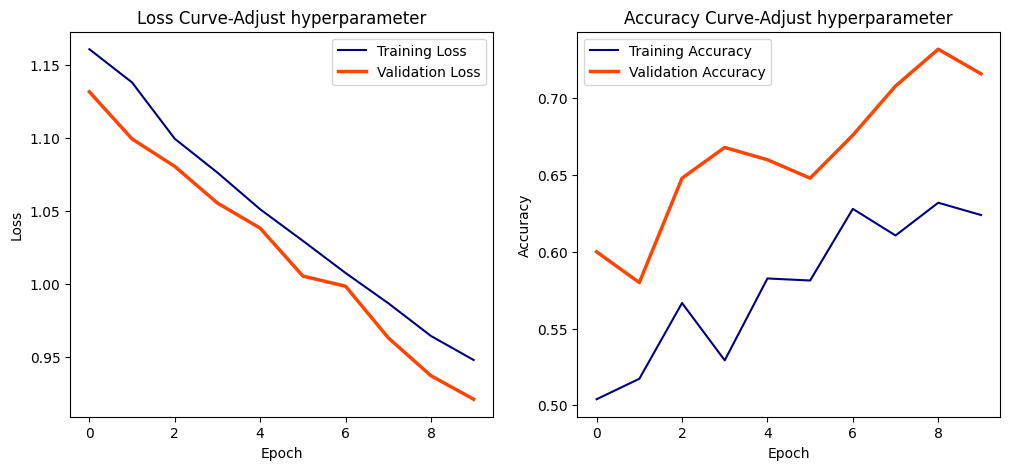

Adjust hyperparameter AUC: 0.4778


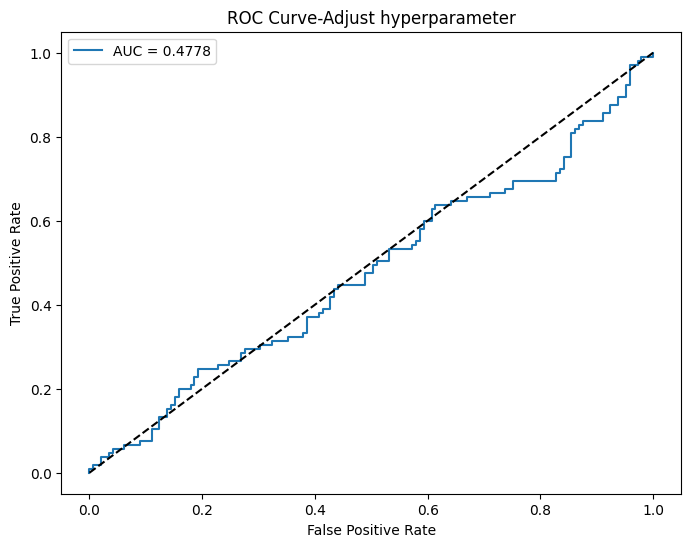

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(complex_history.history['loss'], label='Training Loss', color='navy')
plt.plot(complex_history.history['val_loss'], label='Validation Loss', color='orangered',linewidth='2.5')
plt.title('Loss Curve-Adjust hyperparameter')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(complex_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(complex_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy Curve-Adjust hyperparameter')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# AUC评估
# 获取所有验证数据的预测概率
val_generator.reset()  # 重置生成器
y_pred_prob = complex_model.predict(val_generator, verbose=0).ravel()
y_true = val_generator.classes
# 计算AUC
complex_auc = roc_auc_score(y_true, y_pred_prob)
print(f"Adjust hyperparameter AUC: {complex_auc:.4f}")

# ROC曲线
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)


# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {complex_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # 随机猜测的基线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Adjust hyperparameter')
plt.legend()
plt.show()


**Compare the two models**


In [13]:
print(f"Sample CNN: {cnn_val_accuracy:.4f}")
print(f"Adjust hyperparameter: {complex_val_accuracy:.4f}")
print(f"Rise: {(complex_val_accuracy - cnn_val_accuracy) * 100:.2f}%")

Sample CNN: 0.7600
Adjust hyperparameter: 0.7160
Rise: -4.40%


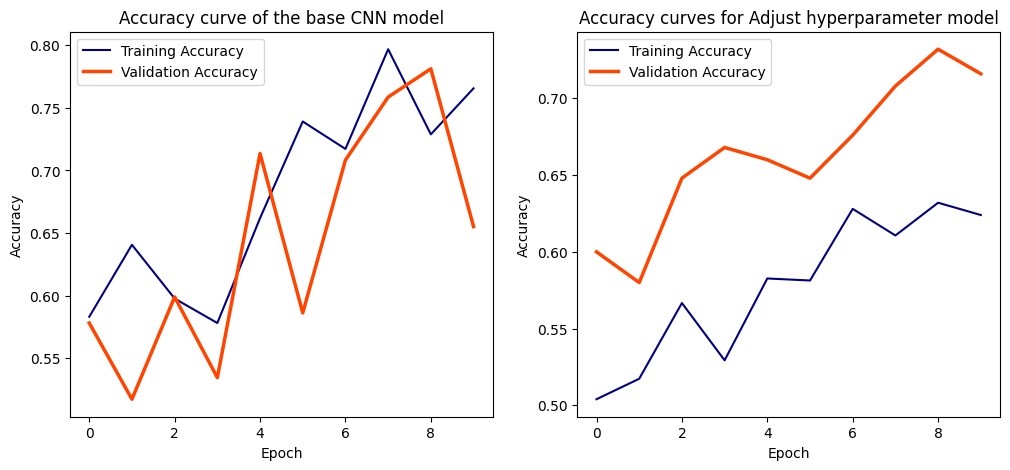

In [14]:
# CNN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy Curve-Adjust hyperparameter')

plt.title('Accuracy curve of the base CNN model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust
plt.subplot(1, 2, 2)
plt.plot(complex_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(complex_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy curves for Adjust hyperparameter model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


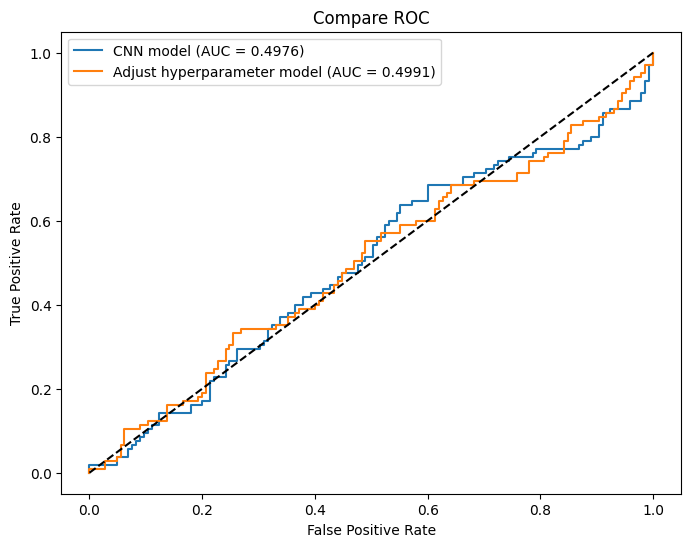

In [15]:
#compare ROC and AUC
cnn_pred_prob = cnn_model.predict(val_generator).ravel()
complex_pred_prob = complex_model.predict(val_generator).ravel()

y_val = val_generator.classes

# ROC
cnn_fpr, cnn_tpr, _ = roc_curve(y_val, cnn_pred_prob)
complex_fpr, complex_tpr, _ = roc_curve(y_val, complex_pred_prob)

# AUC
cnn_auc = roc_auc_score(y_val, cnn_pred_prob)
complex_auc = roc_auc_score(y_val, complex_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN model (AUC = {cnn_auc:.4f})')
plt.plot(complex_fpr, complex_tpr, label=f'Adjust hyperparameter model (AUC = {complex_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Compare ROC')
plt.legend()
plt.show()

In [ ]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Predict on test data
test_generator.reset()
predictions = complex_model.predict(test_generator, steps=test_generator.samples)

# Prepare the submission DataFrame
filenames = test_generator.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission.csv', index=False)

print("submission.csv file created successfully!")

Found 57458 validated image filenames.
   13/57458 ━━━━━━━━━━━━━━━━━━━━ 8:15 9ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33689/57458 ━━━━━━━━━━━━━━━━━━━━ 4:04 10ms/step